<a href="https://colab.research.google.com/github/bdanzi/MLHackathon2023/blob/main/Final_ML_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ML challenge
The first part of this code merge some signal and background that has to be given to the student without the y_true!

In [1]:
!fusermount -u drive
!pip install uproot
!pip install awkward
files = {
    "VBF_HToZZTo4mu.root" : "vcLkNaCniBdKARm",
    "GluGluHToZZTo4mu.root": "IWxhbX0BJzZpWCj",
    "ZZTo4mu.root"       : "5ZGAWxY5xRUCqcp",
    #"VBF_HToZZTo4e.root": "dBdaKwA13bygU8c",
    #"GluGluHToZZTo4e.root": "2DxFLqLtjkbWFdM",
    #"ZZTo4e.root"     : "NhAutemXTrVunU0",
    #"ntuple_qqH_ZZ4mu.root": "s8TRNu0vUsxfhuQ", #original ntuples of the exercise
    #"ntuple_bkg_ZZ4mu.root": "IWEoD7cYN71ewDw"
    }
!rm -f *.root
import os
for file in files.items():
  if not os.path.exists(file[0]):
    b = os.system ( "wget -O %s --no-check-certificate 'https://recascloud.ba.infn.it/index.php/s/%s/download'" % file )
    if b: raise IOError ( "Error in downloading the file %s : (%s)" % file )

fusermount: failed to unmount /content/drive: No such file or directory
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.9/332.9 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 618.4/618.4 kB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 57.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#import libraries
import uproot
import numpy as np
import pandas as pd
import h5py
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta
from tensorflow.keras.layers import Input, Activation, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import utils
from tensorflow import random as tf_random
from keras.utils import plot_model
import random as python_random
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix,accuracy_score , precision_score , recall_score , precision_recall_curve , roc_curve, auc , roc_auc_score


In [3]:

# Fix random seed for reproducibility

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
seed = 7
np.random.seed(seed)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(seed)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf_random.set_seed(seed)

# Defying what is background and signal we are interested in

treename = 'HZZ4LeptonsAnalysisReduced'
filename = {}
upfile = {}
params = {}
df = {}

filename['sig'] = 'VBF_HToZZTo4mu.root'
filename['bkg_ggHtoZZto4mu'] = 'GluGluHToZZTo4mu.root'
filename['bkg_ZZto4mu'] = 'ZZTo4mu.root'
#filename['sig'] = 'VBF_HToZZTo4e.root'
#filename['bkg_ggHtoZZto4e'] = 'GluGluHToZZTo4e.root'
#filename['bkg_ZZto4e'] = 'ZZTo4e.root'

#filename['sig'] = 'ntuple_bkg_ZZ4mu.root'
#filename['bkg'] = 'ntuple_qqH_ZZ4mu.root'

#Using these if you are using your mounted drive
#filename['sig'] = base_dir+'Data/ntuple_qqH_ZZ4mu.root'
#filename['bkg'] = base_dir+'Data/ntuple_bkg_ZZ4mu.root'
#filename['sig'] = base_dir+'Data/output_VBF_HToZZTo4L_M125_13TeV_powheg2_JHUGenV7011_pythia8.root' #qqH->ZZ->4l 2018 ntuples
#filename['bkg'] = base_dir+'Data/output_ZZJJTo4L_EWK_TuneCP5_13TeV-madgraph-pythia8.root'
#filename['bkg'] = base_dir+'Data/output_GluGluToContinToZZTo4mu_13TeV_MCFM701_pythia8.root'
#filename['bkg_ggH'] = base_dir+'Data/output_GluGluHToZZTo4L_M125_13TeV_powheg2_minloHJJ_JHUGenV7011_pythia8.root'
#filename['bkg_ZZto4L'] = base_dir+'Data/output_ZZTo4L_TuneCP5_13TeV_powheg_pythia8.root'


# Variables from Root Tree that must be copyed to PANDA dataframe (df)
VARS = [ 'f_run', 'f_event', 'f_weight', \
        'f_massjj', 'f_deltajj', 'f_mass4l', 'f_Z1mass' , 'f_Z2mass', \
        'f_lept1_pt','f_lept1_eta','f_lept1_phi', \
        'f_lept2_pt','f_lept2_eta','f_lept2_phi', \
        'f_lept3_pt','f_lept3_eta','f_lept3_phi', \
        'f_lept4_pt','f_lept4_eta','f_lept4_phi', \
        'f_jet1_pt','f_jet1_eta','f_jet1_phi', \
        'f_jet2_pt','f_jet2_eta','f_jet2_phi' ]

#checking the dimensions of the df
NDIM = len(VARS)
#26 variables
print("Number of kinematic variables imported from the ROOT files = %d"% NDIM)

upfile['sig'] = uproot.open(filename['sig'])
upfile['bkg_ggHtoZZto4mu'] = uproot.open(filename['bkg_ggHtoZZto4mu'])
upfile['bkg_ZZto4mu'] = uproot.open(filename['bkg_ZZto4mu'])
#Define the signal and bkg before applying physical requirement

df['sig'] = pd.DataFrame(upfile['sig'][treename].arrays(VARS, library="np"),columns=VARS)
print(df['sig'].shape)


df['bkg_ggHtoZZto4mu'] = pd.DataFrame(upfile['bkg_ggHtoZZto4mu'][treename].arrays(VARS, library="np"),columns=VARS)
df['bkg_ZZto4mu'] = pd.DataFrame(upfile['bkg_ZZto4mu'][treename].arrays(VARS, library="np"),columns=VARS)
df['bkg']= pd.concat([df['bkg_ZZto4mu'],df['bkg_ggHtoZZto4mu']])

# Remove undefined variable entries VARS[i] <= -999

for i in range(NDIM):
    df['sig'] = df['sig'][(df['sig'][VARS[i]] > -999)]
    df['bkg']= df['bkg'][(df['bkg'][VARS[i]] > -999)]

# Add the columnisSignal to the dataframe containing the truth information
#i.e. it tells if that particular event is signal (isSignal=1) or background (isSignal=0)

df['sig']['isSignal'] = np.ones(len(df['sig']))
df['bkg']['isSignal'] = np.zeros(len(df['bkg']))
print("Number of Signal events = %d " %len(df['sig']['isSignal']))
print("Number of Background events = %d " %len(df['bkg']['isSignal']))


# Renormalizes the events weights to give unit sum in the signal and background dataframes


df['sig']['f_weight']=df['sig']['f_weight']/df['sig']['f_weight'].sum(axis=0)
df['bkg']['f_weight']=df['bkg']['f_weight']/df['bkg']['f_weight'].sum(axis=0)

print("Number SIG events=", len(df['sig']['f_weight']))
print("Number BKG events=", len(df['bkg']['f_weight']))

# Concatenate the signal and background dfs in a single data frame
df_all = pd.concat([df['sig'],df['bkg']])

# Random shuffles the data set to mix signal and background events before the splitting between train and test samples
df_all = shuffle(df_all)



Number of kinematic variables imported from the ROOT files = 26
(44906, 26)
Number of Signal events = 28381 
Number of Background events = 136179 
Number SIG events= 28381
Number BKG events= 136179


In [4]:
# Filter dataframe leaving just NN and RF input variables

#NN_VARS= ['f_massjj', 'f_deltajj', 'f_mass4l', 'f_Z1mass' , 'f_Z2mass']
NN_VARS = [ 'f_lept1_pt','f_lept1_eta','f_lept1_phi', \
          'f_lept2_pt','f_lept2_eta','f_lept2_phi', \
          'f_lept3_pt','f_lept3_eta','f_lept3_phi', \
          'f_lept4_pt','f_lept4_eta','f_lept4_phi', \
          'f_jet1_pt','f_jet1_eta','f_jet1_phi', \
          'f_jet2_pt','f_jet2_eta','f_jet2_phi']

df_input  = df_all.filter(NN_VARS)
df_target = df_all.filter(['isSignal']) #flag
df_weights = df_all.filter(['f_weight']) #the weights are also important to give as input to the training

# Transform dataframes to numpy arrays of float32 (X->NN input , Y->NN target output , W-> event weights)

NINPUT=len(NN_VARS)
print("Number NN input variables=",NINPUT)
print("NN input variables=",NN_VARS)
X  = np.asarray( df_input.values ).astype(np.float32)
Y  = np.asarray( df_target.values ).astype(np.float32)
W  = np.asarray( df_weights.values ).astype(np.float32)
print(X.shape)
print(Y.shape)
print(W.shape)
print('\n')


Number NN input variables= 18
NN input variables= ['f_lept1_pt', 'f_lept1_eta', 'f_lept1_phi', 'f_lept2_pt', 'f_lept2_eta', 'f_lept2_phi', 'f_lept3_pt', 'f_lept3_eta', 'f_lept3_phi', 'f_lept4_pt', 'f_lept4_eta', 'f_lept4_phi', 'f_jet1_pt', 'f_jet1_eta', 'f_jet1_phi', 'f_jet2_pt', 'f_jet2_eta', 'f_jet2_phi']
(164560, 18)
(164560, 1)
(164560, 1)




In [5]:
from google.colab import files
df_input.to_csv('input.csv')
files.download('input.csv')
print('DONE!')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

DONE!


#Second part: analysis of student answer

In [6]:

files = {
    "Group_5_answer.csv": "goGHJP2HzrWCmTU",
    }
!rm -f *.root
import os
for file in files.items():
  if not os.path.exists(file[0]):
    b = os.system ( "wget -O %s --no-check-certificate 'https://recascloud.ba.infn.it/index.php/s/%s/download'" % file )
    if b: raise IOError ( "Error in downloading the file %s : (%s)" % file )

filename = {}

df_challenge = {}
df_answer = {}
#Define the signal and bkg before applying physical requirement


filename['answer1'] = 'Group_5_answer.csv'
df_answer['answer1']  = pd.read_csv(filename['answer1'])

print(df_answer['answer1'].shape)
Y_prediction = df_answer['answer1'].filter('0')
print(Y_prediction)

(164560, 2)
                   0
0       2.819710e-05
1       2.776217e-01
2       1.710057e-04
3       1.609763e-09
4       4.671592e-01
...              ...
164555  8.107454e-03
164556  5.528033e-04
164557  2.459846e-01
164558  2.307401e-05
164559  8.271962e-01

[164560 rows x 1 columns]


In [7]:
fpr, tpr, thresholds = roc_curve( y_true= Y,  y_score= Y_prediction, sample_weight=W )
roc_auc = auc(fpr, tpr)

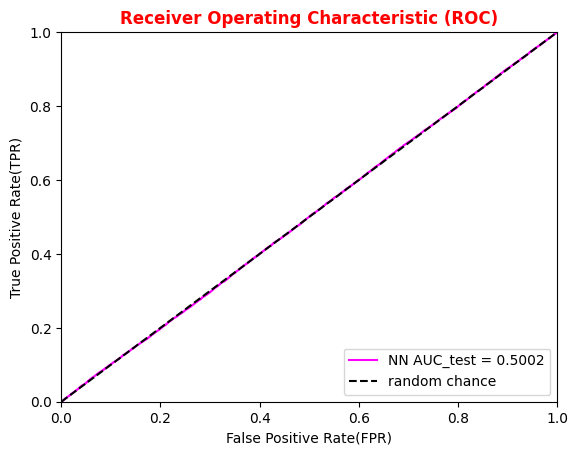

In [8]:
plt.plot(fpr, tpr, color='magenta', label='NN AUC_test = %.4f' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='k', label='random chance')
plt.xlim([0, 1.0]) #fpr
plt.ylim([0, 1.0]) #tpr
plt.xlabel('False Positive Rate(FPR)')
plt.ylabel('True Positive Rate(TPR)')
plt.title('Receiver Operating Characteristic (ROC)',fontsize=12,fontweight='bold', color='r')
plt.legend(loc="lower right")
plt.show()


In [9]:
print('Answer student: %s' % filename['answer1'])
print('AUC score = %.4f' % (roc_auc))

Answer student: Group_5_answer.csv
AUC score = 0.5002
